Install Libraries

In [95]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score, accuracy_score, median_absolute_error,mean_squared_log_error
from sklearn.feature_selection import RFECV
import pickle
import shap
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Load Dataset

In [96]:
generalStats_pos = pd.read_csv('E:/Inzynierka/generalStats_pos - generalStats_pos.csv')

Data cleaning

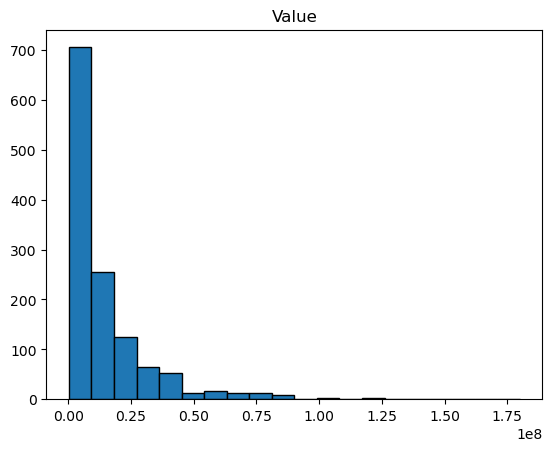

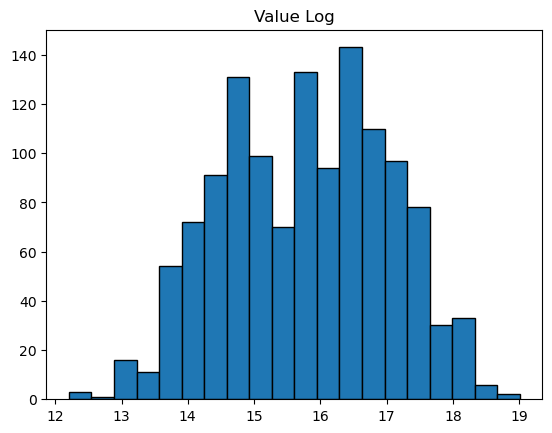

In [97]:
generalStats_pos['value_log'] = generalStats_pos['value'].apply(lambda x: math.log(x))
generalStats_pos = generalStats_pos.dropna()
sorted_data = np.sort(generalStats_pos['value'])
plt.hist(sorted_data, edgecolor='black', bins=20)
plt.title('Value')
plt.show()

sorted_data = np.sort(generalStats_pos['value_log'])
plt.hist(sorted_data, edgecolor='black', bins=20)
plt.title('Value Log')
plt.show()

In [98]:
def calculate_revised_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    msle = mean_squared_log_error(y_true, y_pred)
    median_ae = median_absolute_error(y_true, y_pred)

    return {
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R^2": r2,
        "MAPE": mape,
        "MSLE": msle,
        "Median AE": median_ae
    }

In [99]:
X = generalStats_pos.iloc[:, 3:-2]
y = generalStats_pos.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [100]:
model = ElasticNet()
model.fit(X_train,y_train)
score = model.score(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
print('Score: ', score)

Score:  0.5234563981878155


<class 'pandas.core.series.Series'>
0       0.87
1       1.10
2      -0.23
3       1.06
4       0.90
        ... 
1310   -2.06
1311   -1.85
1314   -2.44
1315   -2.13
1316   -2.82
Name: diff_log, Length: 1274, dtype: float64
<class 'pandas.core.series.Series'>
0      104242560.20
1      100039115.67
2      -31292967.81
3       78298434.45
4       65324909.17
           ...     
1310    -2726605.83
1311    -1616114.36
1314    -2091524.93
1315    -1478243.07
1316    -3160052.52
Name: diff, Length: 1274, dtype: float64
                    Player      value  estimated_value         diff  \
0           Erling Haaland  180000000      75757439.80 104242560.20   
1          Vinicius Júnior  150000000      49960884.33 100039115.67   
10         Martin Ødegaard   90000000     181770077.47 -91770077.47   
5                    Pedri  100000000      21555988.13  78444011.87   
3           Victor Osimhen  120000000      41701565.55  78298434.45   
7        Federico Valverde  100000000      23375176.1

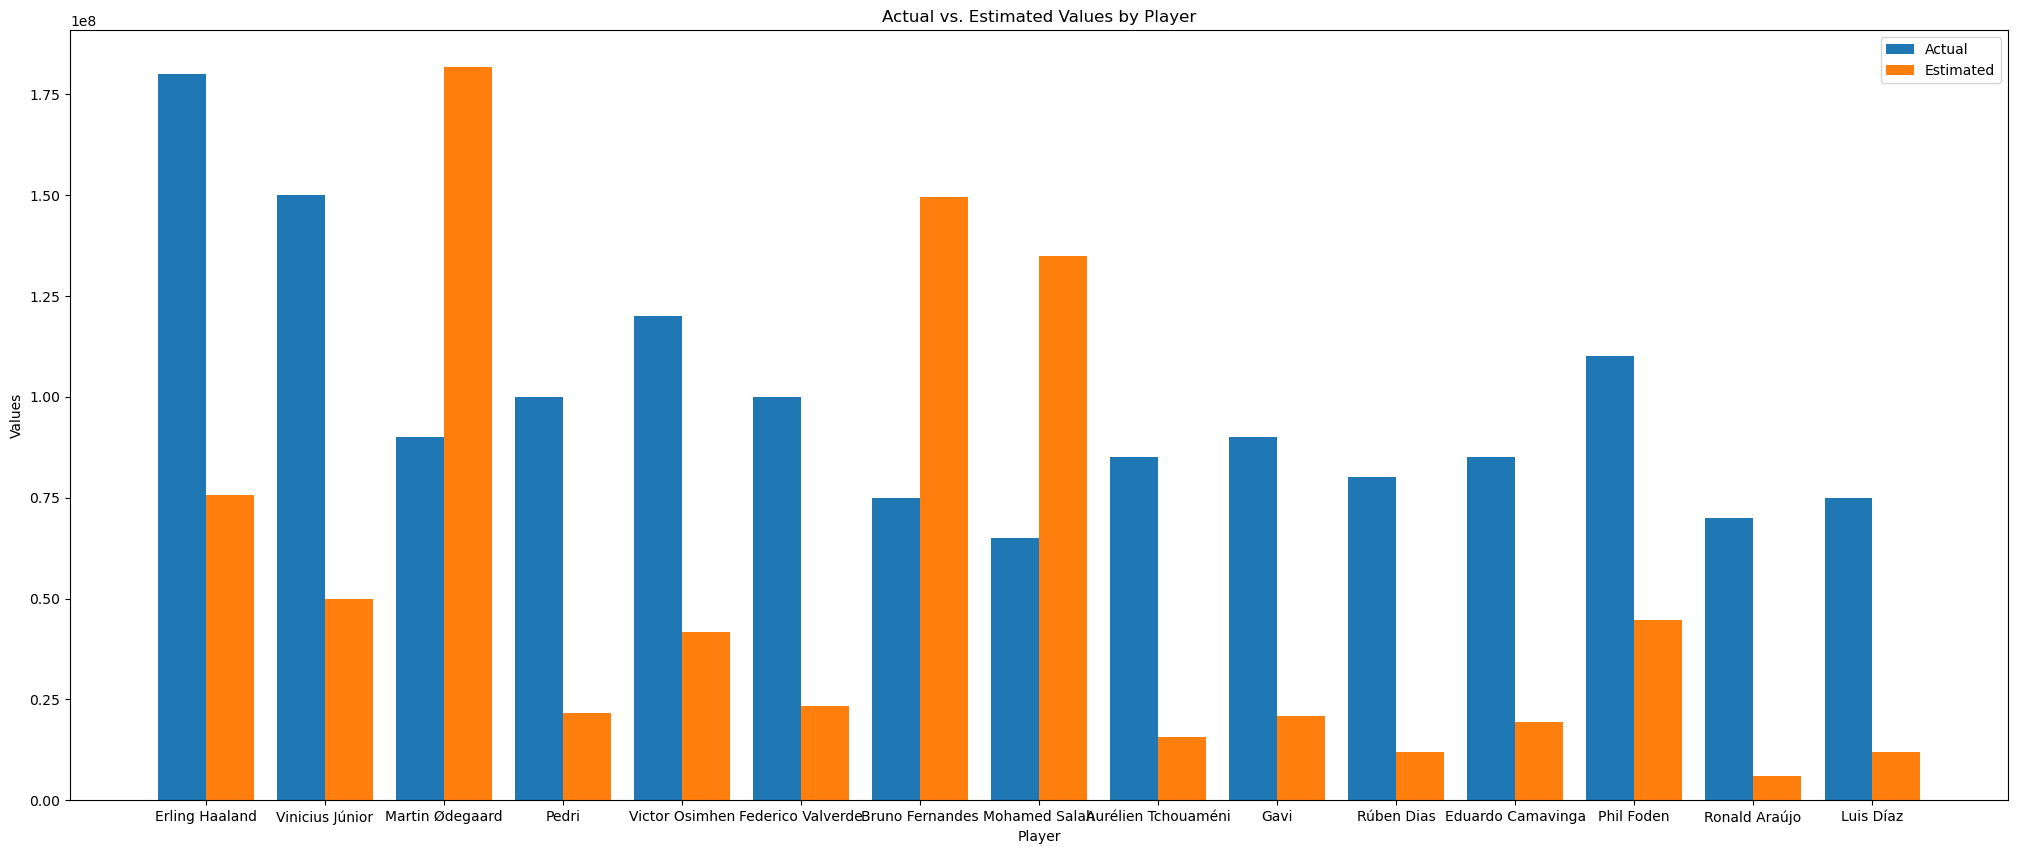

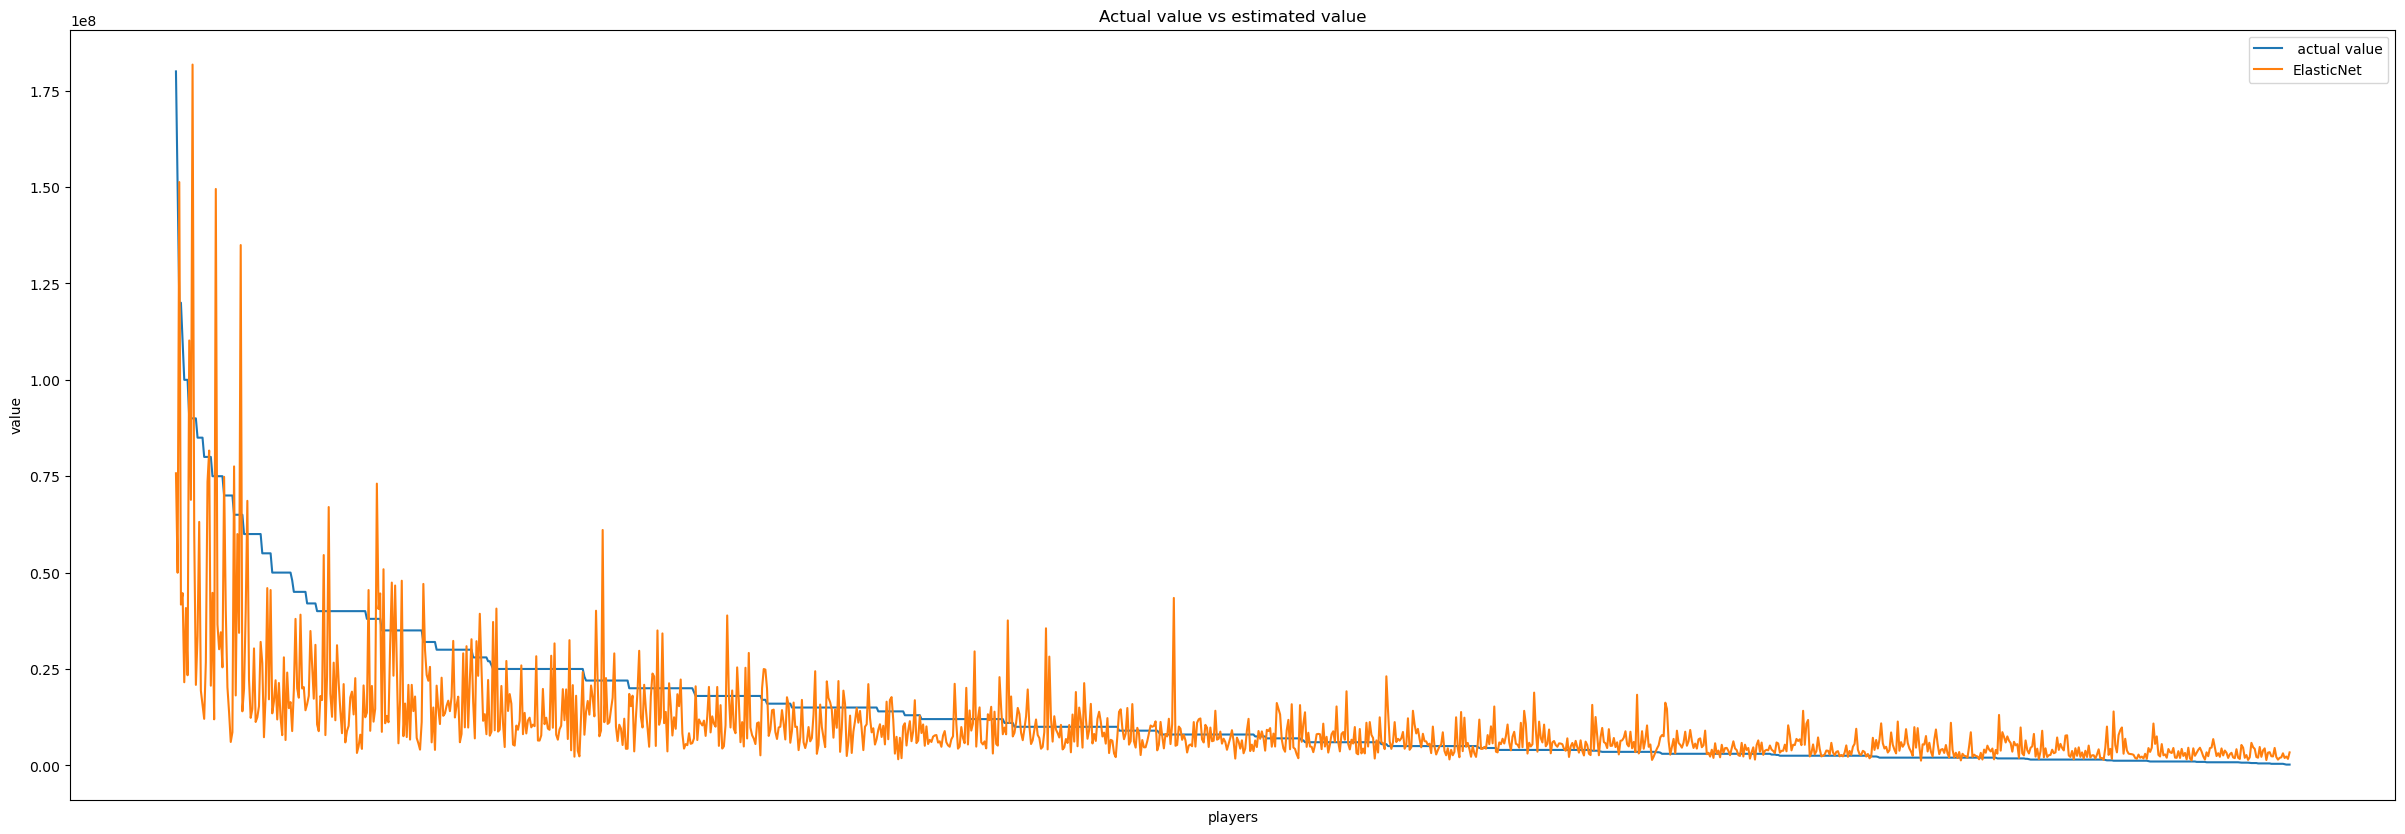

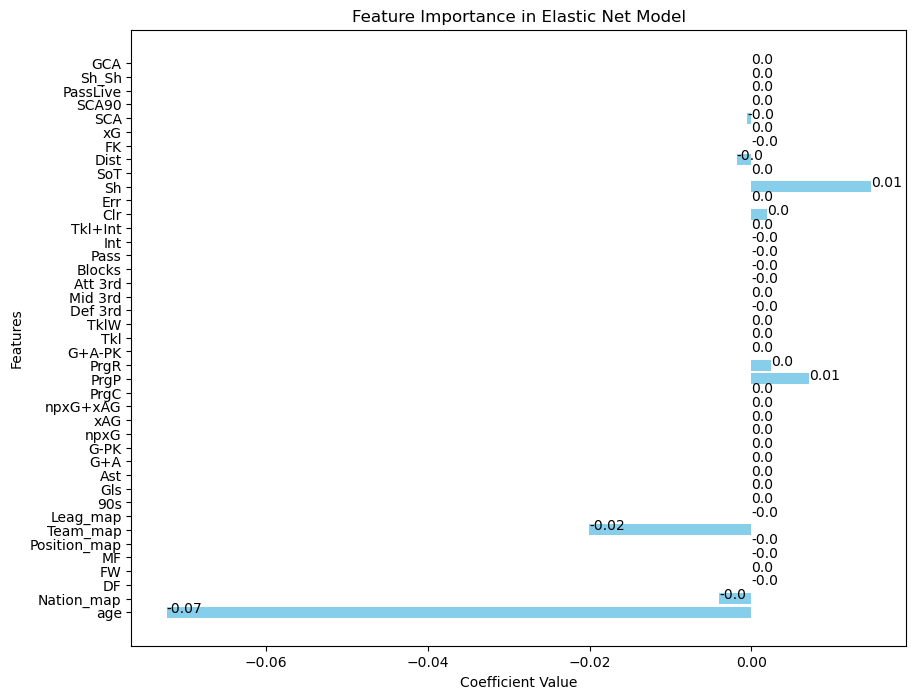

In [101]:
generalStats_pos_local = generalStats_pos.copy()
estimated_value_log = []
for i in range(0,len(generalStats_pos)):
    player_data = generalStats_pos.iloc[i,:].to_frame().transpose()
    player_data = (player_data.iloc[:, 3:-2])
    estimated_value_log.append(float(model.predict(player_data)))



estimated_value = []
generalStats_pos_local['estimated_value_log'] = estimated_value_log
generalStats_pos_local['estimated_value_log'] = generalStats_pos_local['estimated_value_log'].astype(float)
print(type(generalStats_pos_local['estimated_value_log']))
generalStats_pos_local['diff_log'] = generalStats_pos_local['value_log'] - generalStats_pos_local['estimated_value_log']
print(generalStats_pos_local['diff_log'])

for value in generalStats_pos_local['estimated_value_log']:
    estimated_value.append(math.exp(value))
generalStats_pos_local['estimated_value'] = estimated_value
generalStats_pos_local['value'] = generalStats_pos_local['value'].astype(int)
generalStats_pos_local['diff'] = generalStats_pos_local['value'] - generalStats_pos_local['estimated_value']
print(type(generalStats_pos_local['value']))
print(generalStats_pos_local['diff'])

generalStats_pos_local['absolute_diff'] = abs(generalStats_pos_local['diff'])

bestvalued_50 = generalStats_pos_local[['Player','value','estimated_value','diff','absolute_diff']].nlargest(n=50,columns = 'absolute_diff')
print(bestvalued_50)
actual_values = bestvalued_50.head(15)['value']
estimated_values = bestvalued_50.head(15)['estimated_value']
labels = bestvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels) 
print('Mean difference: ', np.mean(generalStats_pos_local['absolute_diff']))
plt.legend()

plt.show()
plt.figure(figsize=(30, 10))  
plt.xlabel('players')
plt.ylabel('value')
plt.title('Actual value vs estimated value')
plt.xticks([])
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['value'], label=' actual value')
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['estimated_value'], label='ElasticNet')


plt.legend()
plt.show()
coefficients = model.coef_

# Assuming feature names are like 'feature1', 'feature2', etc.
feature_names = generalStats_pos.iloc[:, 3:-2].columns.tolist()

# Step 4: Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, coefficients, color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in Elastic Net Model')

# Adding the coefficient values on the bars
for index, value in enumerate(coefficients):
    ax.text(value, index, str(round(value, 2)))

plt.show()

In [102]:
metrics = calculate_revised_metrics(y_test, y_test_pred)
print(metrics)

{'MAE': 0.7228033927307764, 'MSE': 0.8375433879809278, 'RMSE': 0.9151739659654484, 'R^2': 0.47006994405455915, 'MAPE': 4.710966023133882, 'MSLE': 0.003137681524399472, 'Median AE': 0.5722043865019035}


RFE on  Elasticnet

In [103]:
%%capture


estimator = ElasticNet()
selector = RFECV(estimator, cv=5)
selector = selector.fit(X_train, y_train)

print("Suggested number of features: %d" % selector.n_features_)
print("Selected features: %s" % selector.support_)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)



In [104]:
print(type(X_train_selected))

<class 'numpy.ndarray'>


Which features performs the best

In [105]:
selected_fetures = []
keys = generalStats_pos.iloc[:, 3:-2].keys()
for i in range(0,len(selector.support_)-1):
    if selector.support_[i] == True:
        selected_fetures.append(keys[i])
print(selected_fetures)
np.save('E:/Inzynierka/X_train_selected_net.npy',X_train_selected )

['age', 'Nation_map', 'Team_map', 'PrgP', 'PrgR', 'Clr', 'Sh', 'Dist']


Fit the model 

In [106]:
model = ElasticNet()
model.fit(X_train_selected,y_train)
score = model.score(X_train_selected,y_train)
y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)
print('Score: ', score)

Score:  0.5229421001218431


<class 'pandas.core.series.Series'>
0       0.88
1       1.10
2      -0.23
3       1.07
4       0.90
        ... 
1310   -2.06
1311   -1.86
1314   -2.44
1315   -2.13
1316   -2.82
Name: diff_log, Length: 1274, dtype: float64
<class 'pandas.core.series.Series'>
0      105050413.90
1       99852007.59
2      -30696989.46
3       78647890.93
4       65309522.54
           ...     
1310    -2728905.38
1311    -1617828.22
1314    -2096665.16
1315    -1477783.81
1316    -3162014.47
Name: diff, Length: 1274, dtype: float64
                    Player      value  estimated_value         diff  \
0           Erling Haaland  180000000      74949586.10 105050413.90   
1          Vinicius Júnior  150000000      50147992.41  99852007.59   
10         Martin Ødegaard   90000000     182042492.80 -92042492.80   
24         Bruno Fernandes   75000000     153845097.75 -78845097.75   
3           Victor Osimhen  120000000      41352109.07  78647890.93   
5                    Pedri  100000000      21589330.5

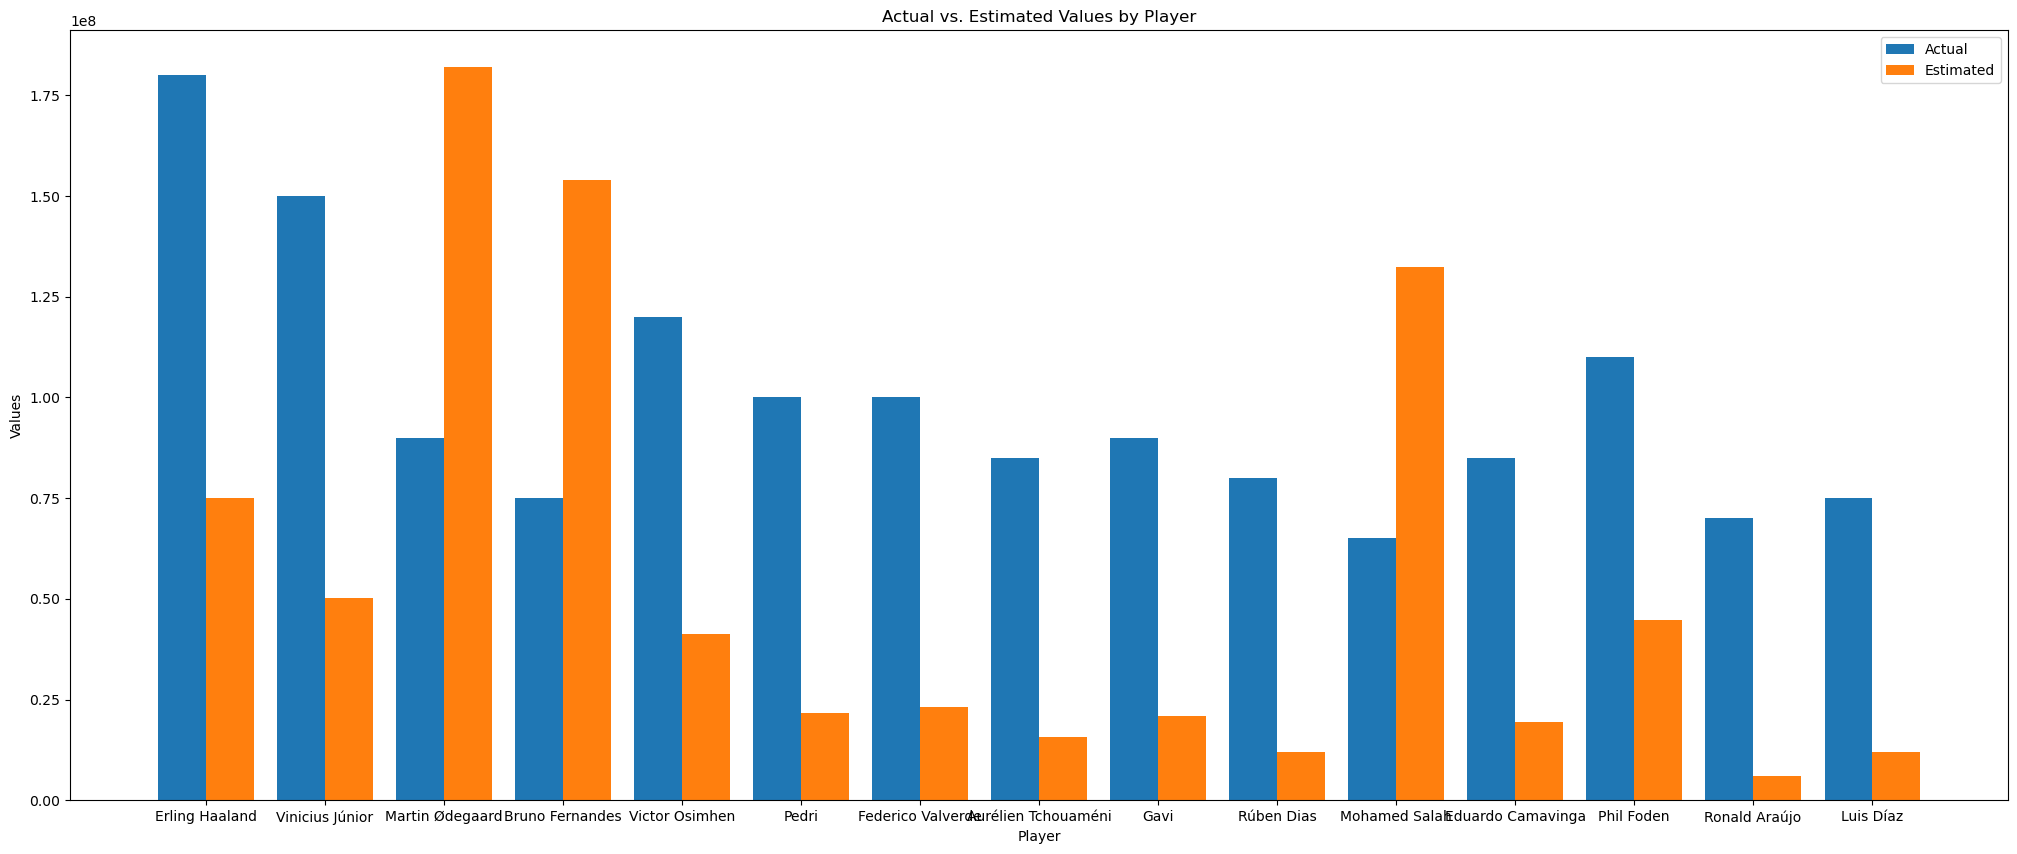

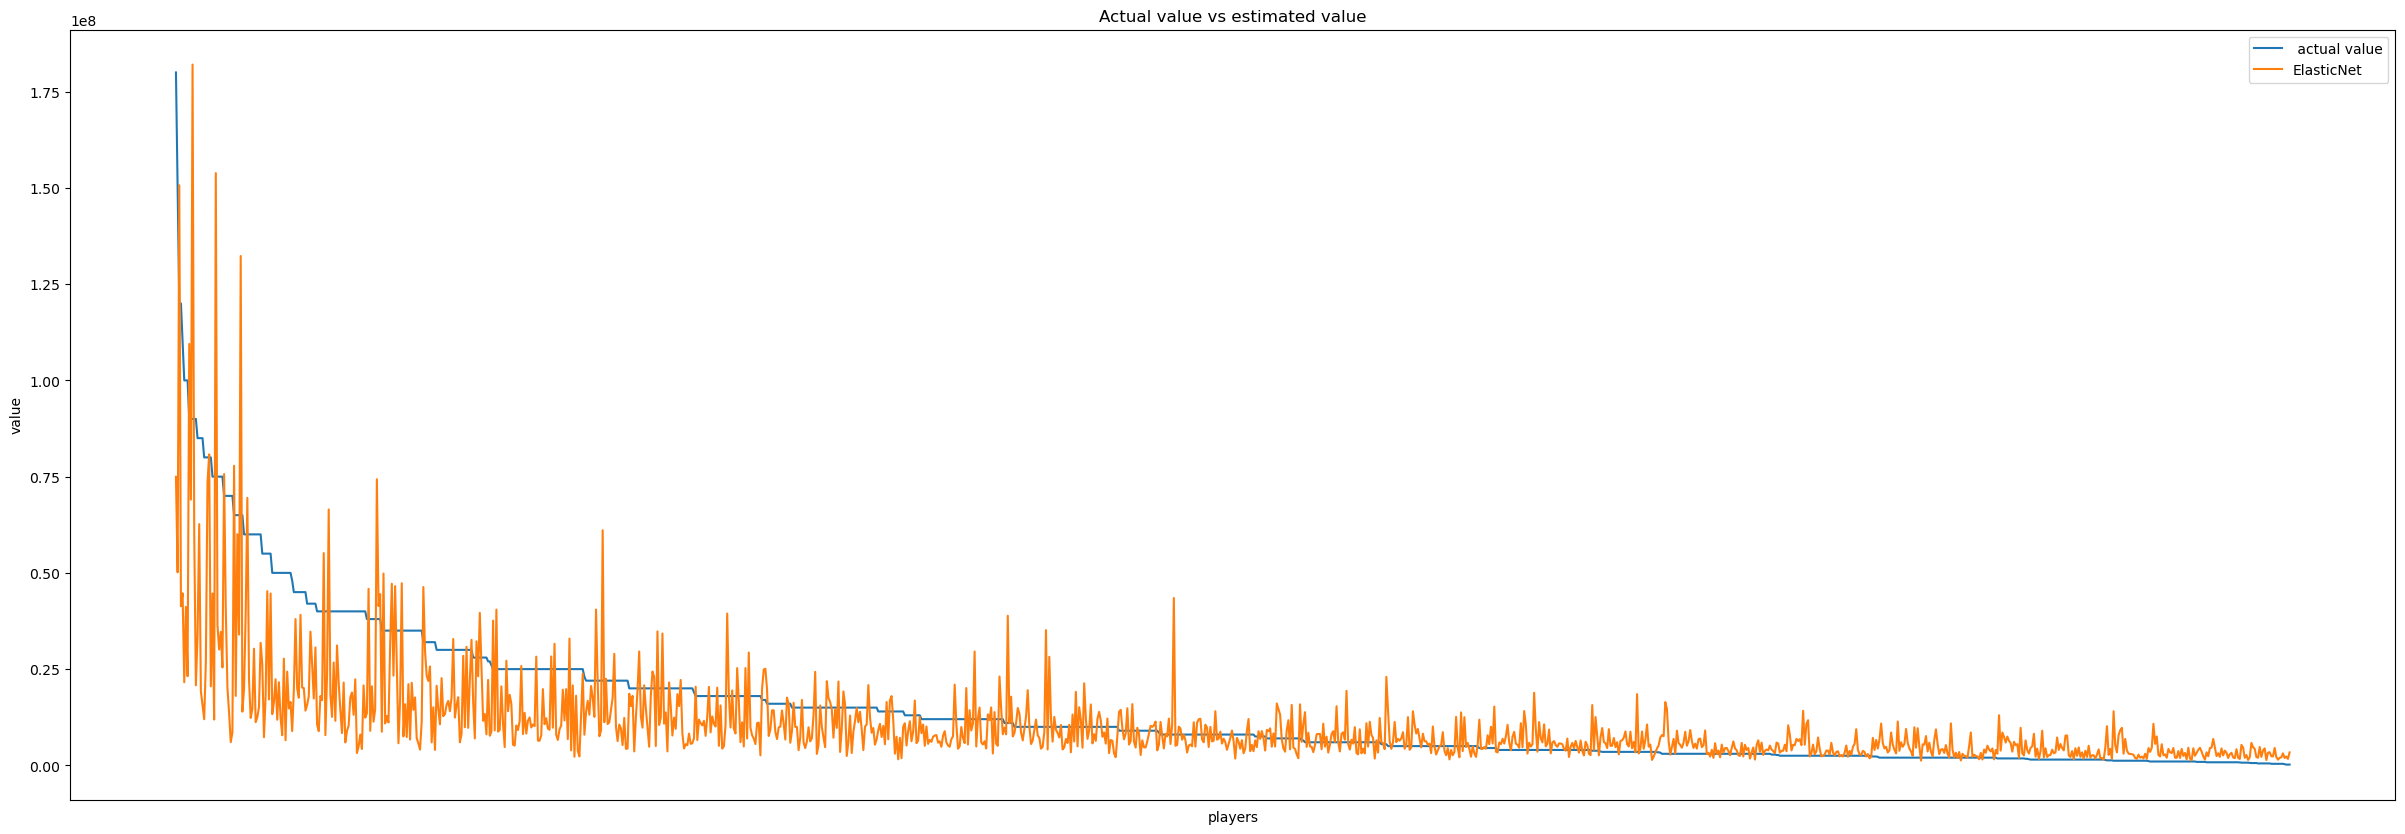

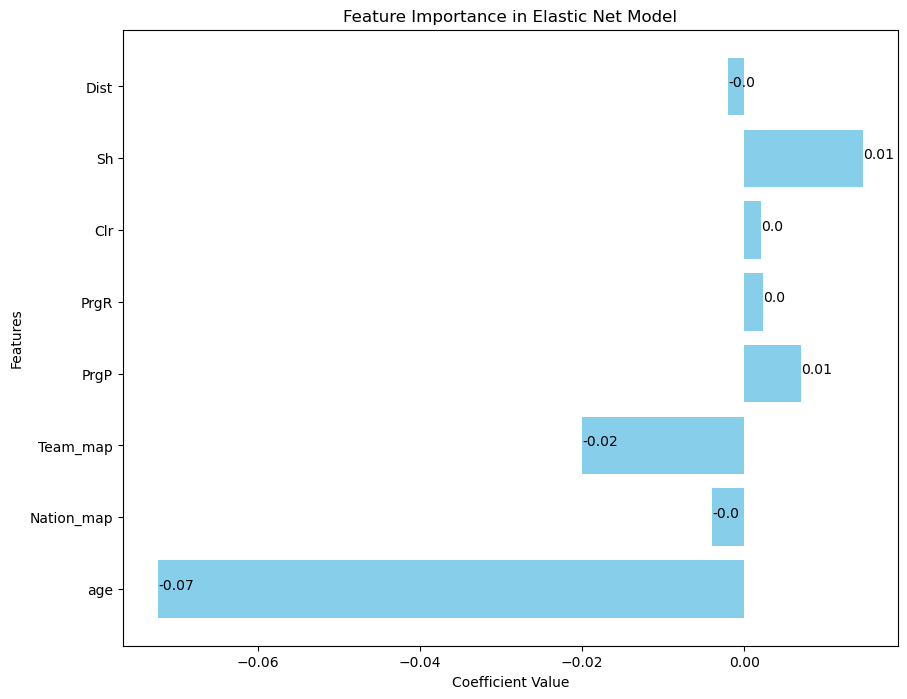

In [107]:
generalStats_pos_local = generalStats_pos.copy()
estimated_value_log = []
for i in range(0,len(generalStats_pos_local)):
    player_data = generalStats_pos_local.iloc[i,:].to_frame().transpose()
    player_data = selector.transform(player_data.iloc[:, 3:-2])
    estimated_value_log.append(float(model.predict(player_data)))



estimated_value = []
generalStats_pos_local['estimated_value_log'] = estimated_value_log
generalStats_pos_local['estimated_value_log'] = generalStats_pos_local['estimated_value_log'].astype(float)
print(type(generalStats_pos_local['estimated_value_log']))
generalStats_pos_local['diff_log'] = generalStats_pos_local['value_log'] - generalStats_pos_local['estimated_value_log']
print(generalStats_pos_local['diff_log'])

for value in generalStats_pos_local['estimated_value_log']:
    estimated_value.append(math.exp(value))
generalStats_pos_local['estimated_value'] = estimated_value
generalStats_pos_local['value'] = generalStats_pos_local['value'].astype(int)
generalStats_pos_local['diff'] = generalStats_pos_local['value'] - generalStats_pos_local['estimated_value']
print(type(generalStats_pos_local['value']))
print(generalStats_pos_local['diff'])

generalStats_pos_local['absolute_diff'] = abs(generalStats_pos_local['diff'])

bestvalued_50 = generalStats_pos_local[['Player','value','estimated_value','diff','absolute_diff']].nlargest(n=50,columns = 'absolute_diff')
print(bestvalued_50)
actual_values = bestvalued_50.head(15)['value']
estimated_values = bestvalued_50.head(15)['estimated_value']
labels = bestvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels) 
print('Mean difference: ', np.mean(generalStats_pos_local['absolute_diff']))
plt.legend()

plt.show()
plt.figure(figsize=(30, 10))  
plt.xlabel('players')
plt.ylabel('value')
plt.title('Actual value vs estimated value')
plt.xticks([])
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['value'], label=' actual value')
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['estimated_value'], label='ElasticNet')


plt.legend()
plt.show()
coefficients = model.coef_

# Assuming feature names are like 'feature1', 'feature2', etc.
feature_names = selected_fetures

# Step 4: Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, coefficients, color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in Elastic Net Model')

# Adding the coefficient values on the bars
for index, value in enumerate(coefficients):
    ax.text(value, index, str(round(value, 2)))

plt.show()

In [108]:
metrics = calculate_revised_metrics(y_test, y_test_pred)
print(metrics)

{'MAE': 0.7231617176437716, 'MSE': 0.8376167717593577, 'RMSE': 0.915214057889933, 'R^2': 0.4700235127050113, 'MAPE': 4.713197473505744, 'MSLE': 0.003137993198654295, 'Median AE': 0.5786913052165055}


In [109]:
%%capture
param_grid = {"max_iter": [ 5000, 10000],
            "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
             "l1_ratio": [0.1, 0.3, 0.5, 0.7, 0.9], }
             
clf = ElasticNet()
gcv = GridSearchCV(estimator=clf,param_grid=param_grid,scoring='r2', cv = 5)
gcv.fit(X_train_selected,y_train)


In [110]:
best_params = gcv.best_params_
model = ElasticNet(**best_params)
model.fit(X_train_selected,y_train)
score = model.score(X_train_selected,y_train)
y_train_pred = model.predict(X_train_selected)
y_test_pred = model.predict(X_test_selected)
print('Score: ', score)

Score:  0.5433460741554634


Perform Hyperparameter tuning by fitting the grid of parameters to the Random Forest and looking for the best combination of features

Evaluate model after hyperparameter tuning

In [111]:
metrics = calculate_revised_metrics(y_test, y_test_pred)
print(metrics)

{'MAE': 0.6920475608296638, 'MSE': 0.7984370976340195, 'RMSE': 0.8935530748836464, 'R^2': 0.4948132575697124, 'MAPE': 4.51793732160362, 'MSLE': 0.003006145745580965, 'Median AE': 0.5629477376823608}


Vizualization of how model estimated values vs real values

<class 'pandas.core.series.Series'>
0       0.52
1       1.05
2      -0.37
3       0.82
4       0.74
        ... 
1310   -2.24
1311   -1.76
1314   -2.10
1315   -1.87
1316   -3.13
Name: diff_log, Length: 1274, dtype: float64
<class 'pandas.core.series.Series'>
0       72806116.24
1       97342665.44
2      -53254445.61
3       66923923.25
4       57299885.71
           ...     
1310    -3364912.91
1311    -1441423.48
1314    -1432220.37
1315    -1102337.19
1316    -4375842.17
Name: diff, Length: 1274, dtype: float64
                    Player      value  estimated_value          diff  \
10         Martin Ødegaard   90000000     261110512.18 -171110512.18   
24         Bruno Fernandes   75000000     174667261.20  -99667261.20   
1          Vinicius Júnior  150000000      52657334.56   97342665.44   
7        Federico Valverde  100000000      24818702.17   75181297.83   
0           Erling Haaland  180000000     107193883.76   72806116.24   
5                    Pedri  100000000      3229

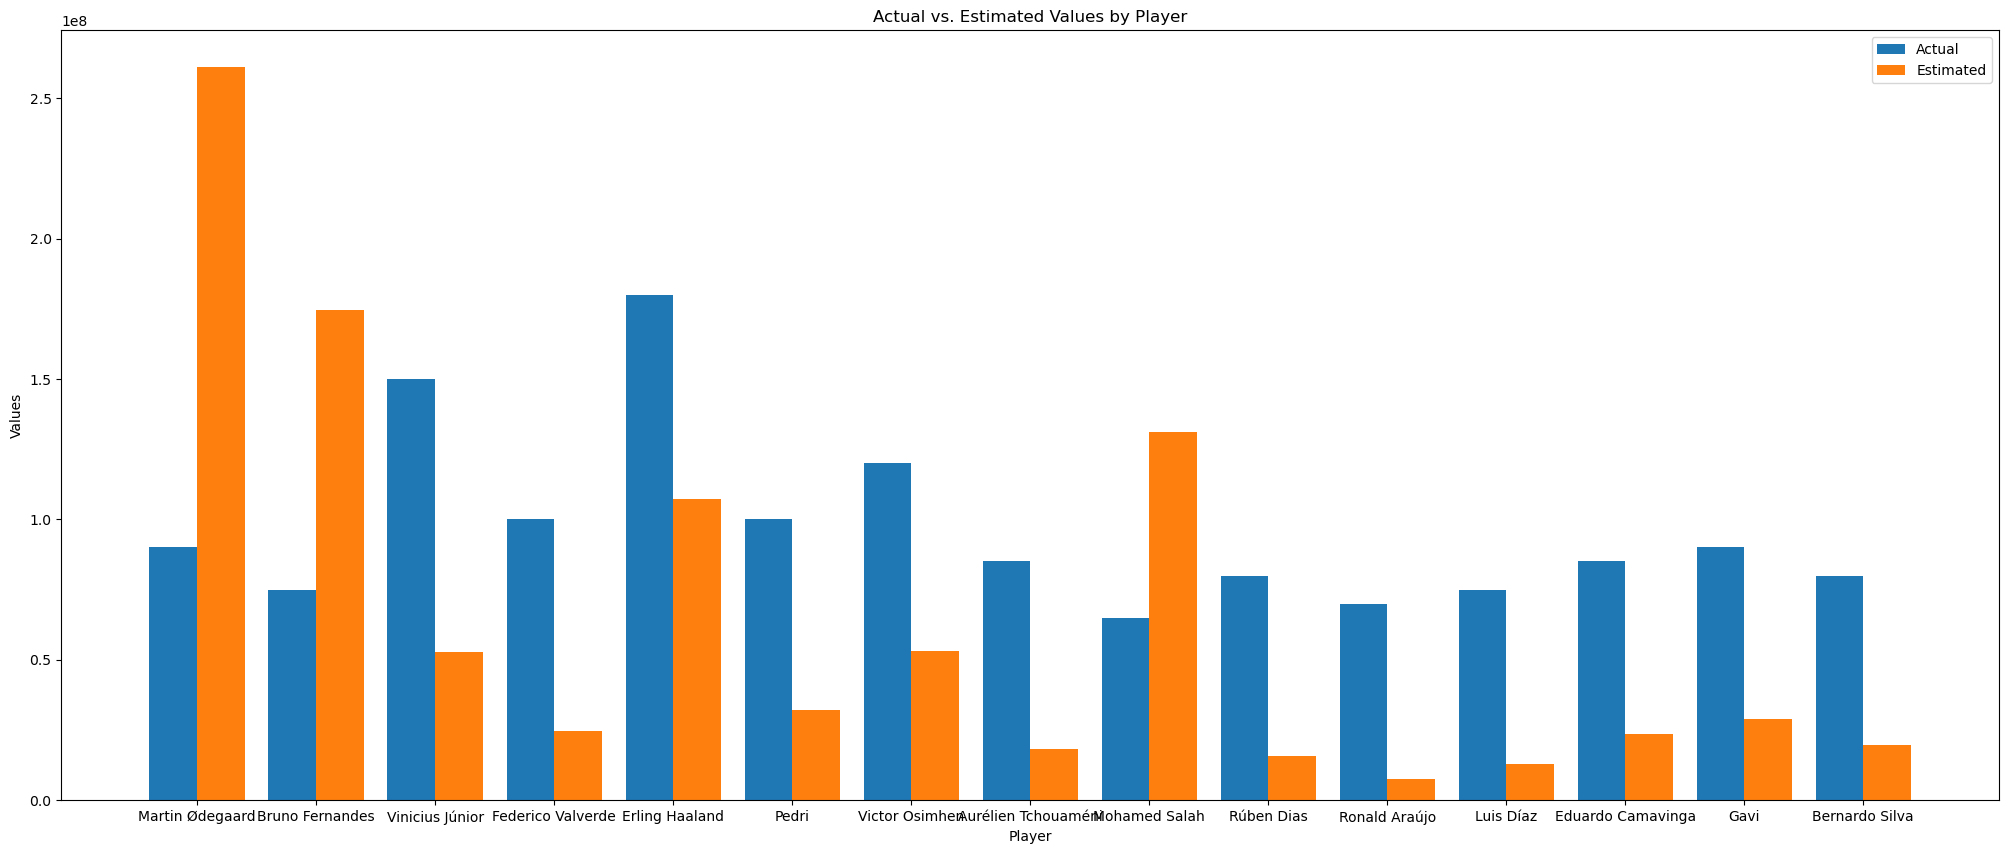

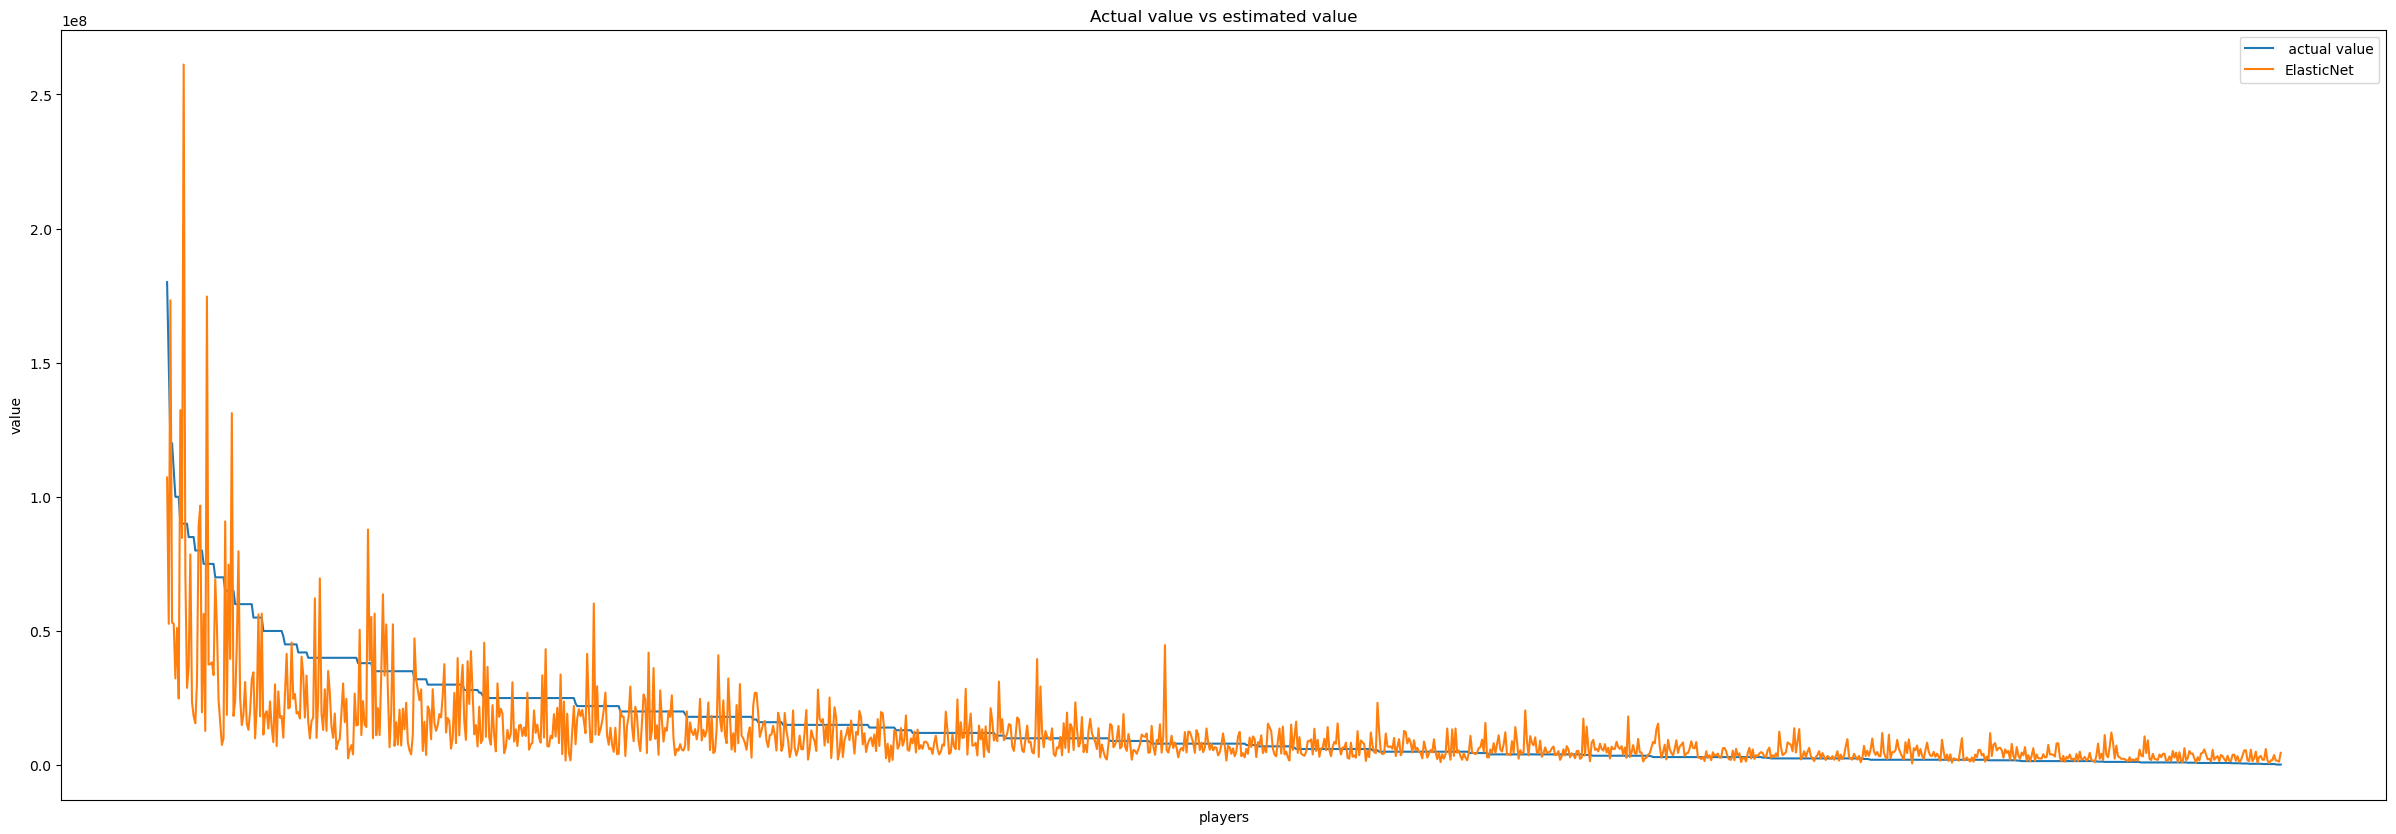

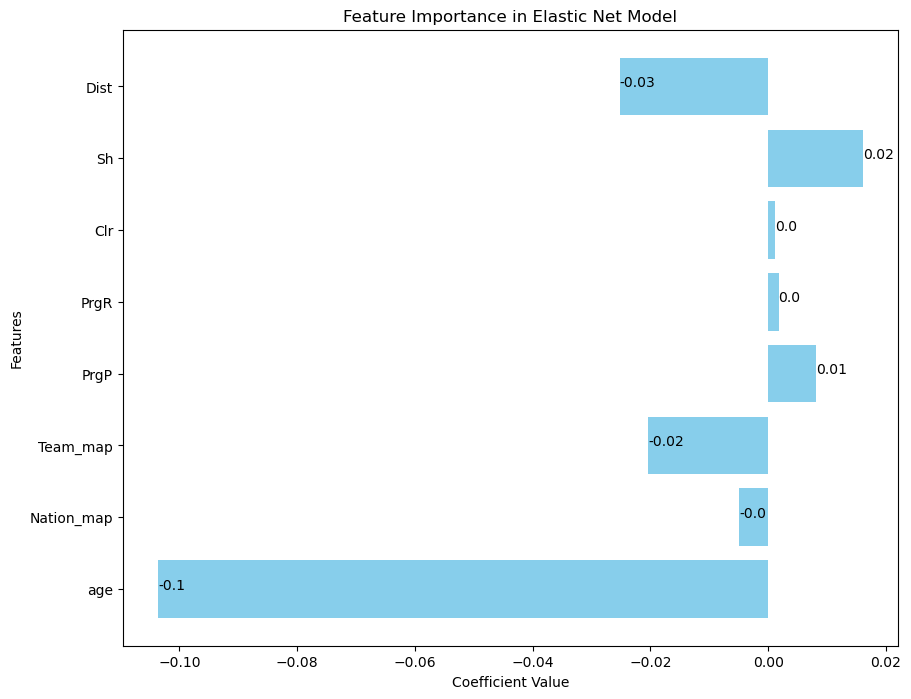

In [112]:
generalStats_pos_local = generalStats_pos.copy()
estimated_value_log = []
for i in range(0,len(generalStats_pos_local)):
    player_data = generalStats_pos_local.iloc[i,:].to_frame().transpose()
    player_data = selector.transform(player_data.iloc[:, 3:-2])
    estimated_value_log.append(float(model.predict(player_data)))



estimated_value = []
generalStats_pos_local['estimated_value_log'] = estimated_value_log
generalStats_pos_local['estimated_value_log'] = generalStats_pos_local['estimated_value_log'].astype(float)
print(type(generalStats_pos_local['estimated_value_log']))
generalStats_pos_local['diff_log'] = generalStats_pos_local['value_log'] - generalStats_pos_local['estimated_value_log']
print(generalStats_pos_local['diff_log'])

for value in generalStats_pos_local['estimated_value_log']:
    estimated_value.append(math.exp(value))
generalStats_pos_local['estimated_value'] = estimated_value
generalStats_pos_local['value'] = generalStats_pos_local['value'].astype(int)
generalStats_pos_local['diff'] = generalStats_pos_local['value'] - generalStats_pos_local['estimated_value']
print(type(generalStats_pos_local['value']))
print(generalStats_pos_local['diff'])

generalStats_pos_local['absolute_diff'] = abs(generalStats_pos_local['diff'])

bestvalued_50 = generalStats_pos_local[['Player','value','estimated_value','diff','absolute_diff']].nlargest(n=50,columns = 'absolute_diff')
print(bestvalued_50)
actual_values = bestvalued_50.head(15)['value']
estimated_values = bestvalued_50.head(15)['estimated_value']
labels = bestvalued_50.head(15)['Player']

x = range(len(labels))
fig, ax = plt.subplots()
fig.set_size_inches(25, 10)
bar_width = 0.4 
actual_bars = plt.bar(x, actual_values, width=bar_width, label='Actual', align='center')
estimated_bars = plt.bar([i + bar_width for i in x], estimated_values, width=bar_width, label='Estimated', align='center')

plt.xlabel('Player')
plt.ylabel('Values')
plt.title('Actual vs. Estimated Values by Player')
plt.xticks([i + bar_width/2 for i in x], labels) 
print('Mean difference: ', np.mean(generalStats_pos_local['absolute_diff']))
plt.legend()

plt.show()
plt.figure(figsize=(30, 10))  
plt.xlabel('players')
plt.ylabel('value')
plt.title('Actual value vs estimated value')
plt.xticks([])
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['value'], label=' actual value')
plt.plot(generalStats_pos_local['Player'], generalStats_pos_local['estimated_value'], label='ElasticNet')


plt.legend()
plt.show()
coefficients = model.coef_

# Assuming feature names are like 'feature1', 'feature2', etc.
feature_names = selected_fetures

# Step 4: Plotting the feature importance

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(feature_names, coefficients, color='skyblue')
ax.set_xlabel('Coefficient Value')
ax.set_ylabel('Features')
ax.set_title('Feature Importance in Elastic Net Model')

# Adding the coefficient values on the bars
for index, value in enumerate(coefficients):
    ax.text(value, index, str(round(value, 2)))

plt.show()

In [113]:
with open('E:/Inzynierka/model/elasticnet.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [114]:
enet = pickle.load(open('E:/Inzynierka/model/elasticnet.pkl', 'rb'))
print(enet.get_params)
print(best_params)

<bound method BaseEstimator.get_params of ElasticNet(alpha=0.1, l1_ratio=0.1, max_iter=5000)>
{'alpha': 0.1, 'l1_ratio': 0.1, 'max_iter': 5000}


In [115]:
generalStats_pos

,#,id,Player,age,Nation_map,DF,FW,MF,Position_map,Team_map,...,Dist,FK,xG,SCA,SCA90,PassLive,Sh_Sh,GCA,value,value_log
0,179,erling_haaland_23,Erling Haaland,23,7,0,1,0,1,8,...,12.60,0.00,28.40,72.00,2.34,48.00,10.00,17.00,180000000.00,19.01
1,1185,vinicius_junior_23,Vinicius Júnior,23,12,0,1,0,1,47,...,16.20,0.00,10.50,161.00,5.13,103.00,11.00,21.00,150000000.00,18.83
2,373,bukayo_saka_21,Bukayo Saka,21,3,0,1,0,1,20,...,16.30,1.00,11.20,161.00,4.56,106.00,11.00,28.00,120000000.00,18.60
3,800,victor_osimhen_24,Victor Osimhen,24,17,0,1,0,1,40,...,12.80,1.00,21.30,80.00,2.80,54.00,11.00,9.00,120000000.00,18.60
4,144,phil_foden_23,Phil Foden,23,3,0,1,0,1,8,...,15.30,1.00,5.90,99.00,4.83,76.00,5.00,14.00,110000000.00,18.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,1407,oscar_urena_20,Oscar Ureña,20,10,0,0,1,2,55,...,16.90,0.00,0.20,2.00,1.80,1.00,1.00,0.00,400000.00,12.90
1311,793,marios_oikonomou_30,Marios Oikonomou,30,58,1,0,0,3,36,...,13.90,0.00,0.30,0.00,0.00,0.00,0.00,0.00,300000.00,12.61
1314,574,daniel_ciofani_38,Daniel Ciofani,38,42,0,1,0,1,26,...,15.70,0.00,5.50,24.00,2.03,17.00,5.00,4.00,200000.00,12.21
1315,753,luca_marrone_33,Luca Marrone,33,42,1,0,0,3,33,...,17.60,0.00,0.10,0.00,0.00,0.00,0.00,0.00,200000.00,12.21
